# ICC Pipeline Evaluation Demo

This notebook demonstrates how to evaluate the results from the ICC pipeline using comprehensive metrics.


In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Import evaluation module
from icc.evaluation import ClusteringEvaluator, evaluate_convergence, plot_convergence

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Step 1: Load Your Data and Results

Load the clustering results from your ICC pipeline run.

In [2]:
# Configure paths
TARGET = "politics"
SPLIT = "test"
DATASET_PATH = Path("../DTrans-MPrompt/Type-Prediction/dataset") / f"{TARGET}_{SPLIT}.json"
# OUTPUT_DIR = Path("outputs") / f"icc_{TARGET}_{SPLIT}_demo"
OUTPUT_DIR = Path("outputs") / f"icc_{TARGET}_{SPLIT}_improved"


print(f"Dataset: {DATASET_PATH}")
print(f"Output: {OUTPUT_DIR}")
print(f"Dataset exists: {DATASET_PATH.exists()}")
print(f"Output exists: {OUTPUT_DIR.exists()}")

Dataset: ../DTrans-MPrompt/Type-Prediction/dataset/politics_test.json
Output: outputs/icc_politics_test_improved
Dataset exists: True
Output exists: True


In [3]:
# Load the original dataset with ground truth labels
with open(DATASET_PATH, 'r') as f:
    data = json.load(f)

print(f"Loaded {len(data)} sentences")
print(f"Sample entry keys: {list(data[0].keys())}")

Loaded 651 sentences
Sample entry keys: ['id', 'str_words', 'tags_ner', 'tags_ner_gold', 'tags_ner_pred']


In [4]:
# Load clustering results
clusters_file = OUTPUT_DIR / "clusters.json"

if clusters_file.exists():
    with open(clusters_file, 'r') as f:
        cluster_results = json.load(f)
    print(f"Loaded {len(cluster_results)} clustered mentions")
else:
    print(f"Clusters file not found: {clusters_file}")
    print("Please run the ICC pipeline first (icc_demo.ipynb)")

Loaded 4168 clustered mentions


## Step 2: Extract Ground Truth and Predicted Labels

Extract the true entity types and predicted cluster assignments.

In [5]:
def extract_entity_labels(data):
    """
    Extract entity mentions and their true labels from dataset
    
    Returns:
        mentions: List of (sentence_id, start, end, text, label) tuples
    """
    mentions = []
    
    for sent_id, sentence in enumerate(data):
        tokens = sentence['str_words']
        ner_tags = sentence.get('tags_ner', [])
        
        if not ner_tags:
            continue
        
        # Parse BIO tags to extract entities
        current_entity = None
        start_idx = None
        
        for i, tag in enumerate(ner_tags):
            if tag.startswith('B-'):
                # Save previous entity if exists
                if current_entity:
                    text = ' '.join(tokens[start_idx:i])
                    mentions.append((sent_id, start_idx, i, text, current_entity))
                
                # Start new entity
                current_entity = tag[2:]
                start_idx = i
            
            elif tag.startswith('I-'):
                # Continue current entity
                if current_entity is None:
                    # Handle case where I- appears without B-
                    current_entity = tag[2:]
                    start_idx = i
            
            elif tag == 'O':
                # End current entity
                if current_entity:
                    text = ' '.join(tokens[start_idx:i])
                    mentions.append((sent_id, start_idx, i, text, current_entity))
                    current_entity = None
        
        # Handle entity at end of sentence
        if current_entity:
            text = ' '.join(tokens[start_idx:])
            mentions.append((sent_id, start_idx, len(tokens), text, current_entity))
    
    return mentions

# Extract ground truth
true_mentions = extract_entity_labels(data)
print(f"Extracted {len(true_mentions)} ground truth mentions")

# Show sample
if true_mentions:
    print("\nSample mentions:")
    for mention in true_mentions[:5]:
        print(f"  {mention}")

Extracted 4209 ground truth mentions

Sample mentions:
  (0, 16, 17, 'Canada', 'country')
  (0, 18, 19, 'Mexico', 'country')
  (0, 20, 21, 'Greece', 'country')
  (1, 0, 1, 'Lincoln', 'politician')
  (1, 2, 3, 'Buell', 'politician')


In [6]:
# Align predicted clusters with ground truth
# Create mapping from span_id to labels

true_label_map = {}
for sent_id, start, end, text, label in true_mentions:
    span_id = (sent_id, start, end)
    true_label_map[span_id] = label

# Extract aligned labels
true_labels = []
pred_labels = []

for item in cluster_results:
    span_id = tuple(item['span_id'])
    
    if span_id in true_label_map:
        true_labels.append(true_label_map[span_id])
        pred_labels.append(item['cluster'])

print(f"Aligned {len(true_labels)} mentions with ground truth")
print(f"Number of unique true classes: {len(set(true_labels))}")
print(f"Number of predicted clusters: {len(set(pred_labels))}")

Aligned 3754 mentions with ground truth
Number of unique true classes: 9
Number of predicted clusters: 10


## Step 3: Comprehensive Evaluation

Evaluate the clustering results using multiple metrics.

In [7]:
# Save evaluation results to file
import numpy as np

# Convert numpy types to Python native types for JSON serialization
def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, dict):
        return {convert_to_serializable(key): convert_to_serializable(value) 
                for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Convert results to serializable format
# serializable_results = convert_to_serializable(results)



In [8]:
# Create evaluator
evaluator = ClusteringEvaluator(true_labels, pred_labels)

# Print comprehensive report
results = evaluator.print_report()


# Save results to file
results_file = OUTPUT_DIR / "evaluation_results.json"
with open(results_file, 'w') as f:
    json.dump(convert_to_serializable(results), f, indent=2)
print(f"\nSaved evaluation results to: {results_file}")





CLUSTERING EVALUATION REPORT

CLUSTERING QUALITY METRICS (No Mapping Required)
----------------------------------------------------------------------
  Adjusted Mutual Information (AMI):  0.3774
  Adjusted Rand Index (ARI):          0.1389
  V-Measure:                           0.3804
  Homogeneity:                         0.3659
  Completeness:                        0.3961

MAPPING-BASED METRICS (Hungarian Algorithm)
----------------------------------------------------------------------
  Precision:                           0.3863
  Recall:                              0.3863
  F1-Score:                            0.3863
  Accuracy:                            0.3863

CLUSTER STATISTICS
----------------------------------------------------------------------
  Number of Predicted Clusters:        10
  Number of True Classes:              9
  Average Cluster Size:                375.40
  Min Cluster Size:                    50
  Max Cluster Size:                    1567
  Std Cluster Si

## Step 4: Detailed Analysis

Analyze cluster purity and quality.

In [9]:
# Get cluster purity information
cluster_purity = evaluator.get_cluster_purity()

# Create DataFrame for better visualization
purity_data = []
for cluster_id, info in cluster_purity.items():
    purity_data.append({
        'Cluster ID': cluster_id,
        'Size': info['size'],
        'Purity': info['purity'],
        'Dominant Class': info['dominant_class'],
        'Dominant Count': info['dominant_count']
    })

purity_df = pd.DataFrame(purity_data).sort_values('Size', ascending=False)

print("\nTop 10 Largest Clusters:")
print(purity_df.head(10).to_string(index=False))

print(f"\nAverage Cluster Purity: {purity_df['Purity'].mean():.4f}")
print(f"Median Cluster Purity: {purity_df['Purity'].median():.4f}")


Top 10 Largest Clusters:
 Cluster ID  Size   Purity Dominant Class  Dominant Count
          7  1567 0.185067   organisation             290
          3   382 0.814136       election             311
          4   306 0.866013 politicalparty             265
          2   271 0.586716     politician             159
          1   262 0.610687         person             160
          5   260 0.611538 politicalparty             159
          6   235 0.957447 politicalparty             225
          9   219 0.867580       location             190
          8   202 0.356436   organisation              72
          0    50 0.680000     politician              34

Average Cluster Purity: 0.6536
Median Cluster Purity: 0.6458


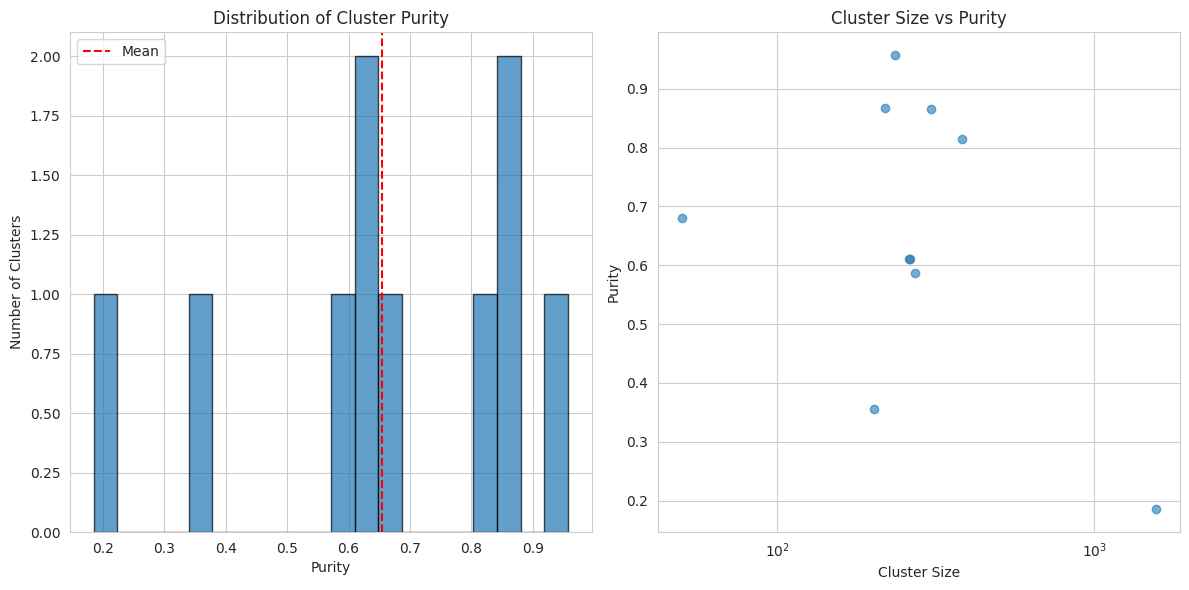

In [10]:
# Plot cluster purity distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(purity_df['Purity'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Purity')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Purity')
plt.axvline(purity_df['Purity'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(purity_df['Size'], purity_df['Purity'], alpha=0.6)
plt.xlabel('Cluster Size')
plt.ylabel('Purity')
plt.title('Cluster Size vs Purity')
plt.xscale('log')

plt.tight_layout()
plt.show()

## Step 5: Confusion Matrix Analysis

Visualize the confusion between predicted clusters and true classes.

In [11]:
# Get optimal mapping
mapping_results = evaluator.mapping_based_metrics()
cluster_mapping = mapping_results['cluster_mapping']

print("Optimal Cluster to Class Mapping:")
print("=" * 50)
for cluster_id, true_class in sorted(cluster_mapping.items())[:20]:
    print(f"  Cluster {cluster_id:3d} -> {true_class}")

if len(cluster_mapping) > 20:
    print(f"  ... and {len(cluster_mapping) - 20} more mappings")

Optimal Cluster to Class Mapping:
  Cluster   0 -> misc
  Cluster   1 -> person
  Cluster   2 -> politician
  Cluster   3 -> election
  Cluster   4 -> politicalparty
  Cluster   5 -> event
  Cluster   7 -> organisation
  Cluster   8 -> country
  Cluster   9 -> location


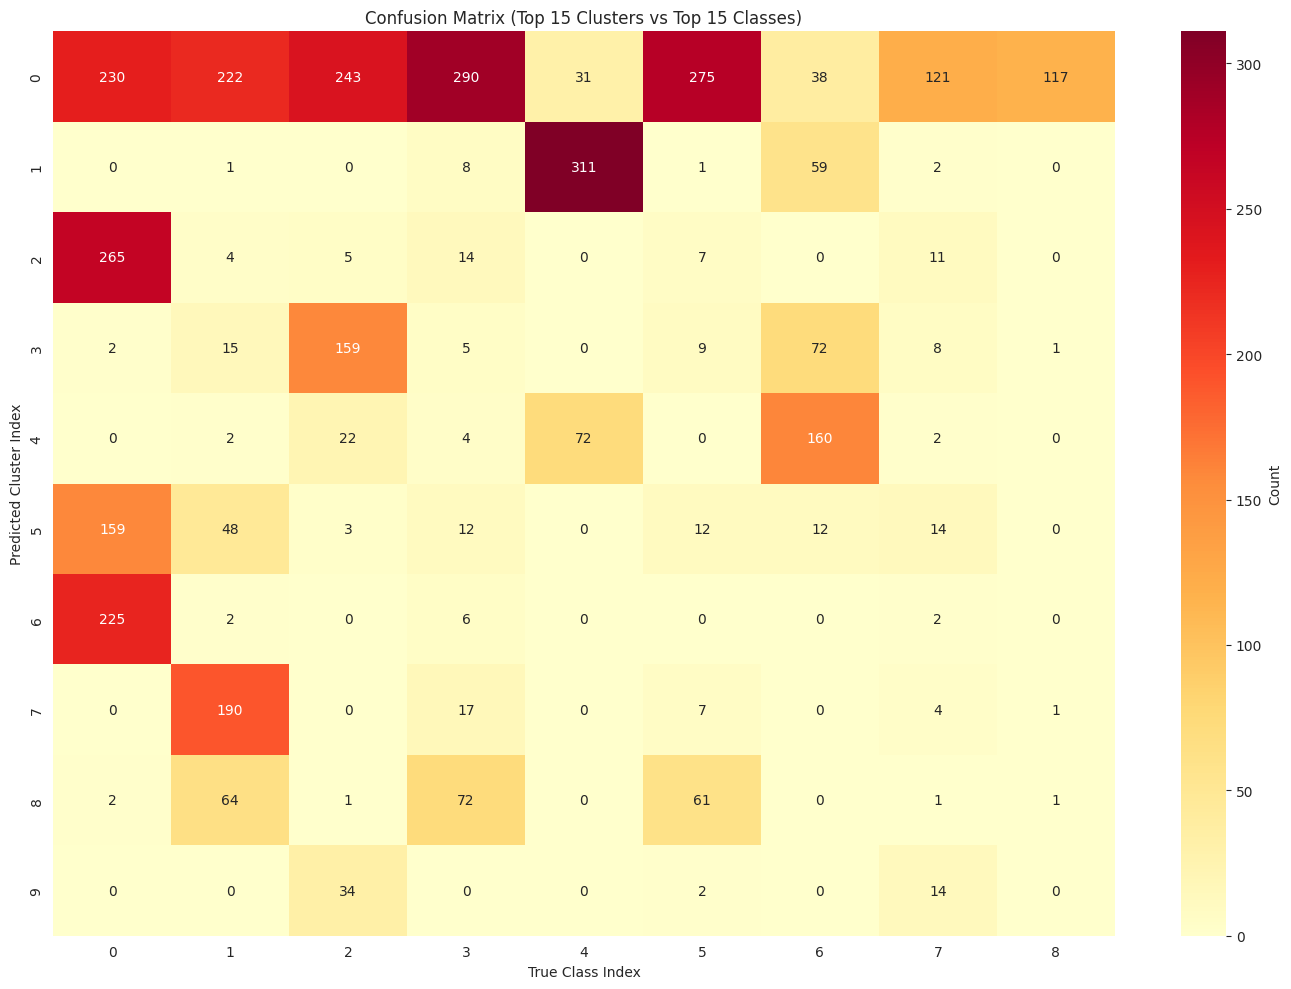

In [12]:
# Plot confusion matrix (top clusters only for readability)
conf_matrix = mapping_results['confusion_matrix']

# Get top N clusters by size
N = 15
cluster_sizes = conf_matrix.sum(axis=1)
top_cluster_indices = np.argsort(cluster_sizes)[-N:][::-1]

# Get top N classes by frequency
class_sizes = conf_matrix.sum(axis=0)
top_class_indices = np.argsort(class_sizes)[-N:][::-1]

# Extract submatrix
sub_matrix = conf_matrix[top_cluster_indices][:, top_class_indices]

plt.figure(figsize=(14, 10))
sns.heatmap(sub_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Top {N} Clusters vs Top {N} Classes)')
plt.xlabel('True Class Index')
plt.ylabel('Predicted Cluster Index')
plt.tight_layout()
plt.show()

## Step 6: Per-Class Performance

Analyze performance for each true entity class.

In [13]:
# Calculate per-class metrics
from collections import Counter

true_label_counts = Counter(true_labels)
pred_label_counts = Counter(pred_labels)

# For each true class, find best matching cluster
class_performance = []

for true_class in sorted(set(true_labels)):
    # Get all instances of this class
    class_mask = np.array(true_labels) == true_class
    class_pred_labels = np.array(pred_labels)[class_mask]
    
    # Find most common predicted cluster
    if len(class_pred_labels) > 0:
        cluster_counts = Counter(class_pred_labels)
        best_cluster = cluster_counts.most_common(1)[0][0]
        best_cluster_count = cluster_counts.most_common(1)[0][1]
        
        # Calculate precision for this class
        precision = best_cluster_count / len(class_pred_labels)
        
        class_performance.append({
            'True Class': true_class,
            'Count': len(class_pred_labels),
            'Best Cluster': best_cluster,
            'Precision': precision,
            'Coverage': best_cluster_count
        })

class_perf_df = pd.DataFrame(class_performance).sort_values('Count', ascending=False)

print("\nPer-Class Performance (Top 15):")
print(class_perf_df.head(15).to_string(index=False))


Per-Class Performance (Top 15):
    True Class  Count  Best Cluster  Precision  Coverage
politicalparty    883             4   0.300113       265
      location    548             7   0.405109       222
    politician    467             7   0.520343       243
  organisation    428             7   0.677570       290
      election    414             3   0.751208       311
       country    374             7   0.735294       275
        person    341             1   0.469208       160
          misc    179             7   0.675978       121
         event    120             7   0.975000       117


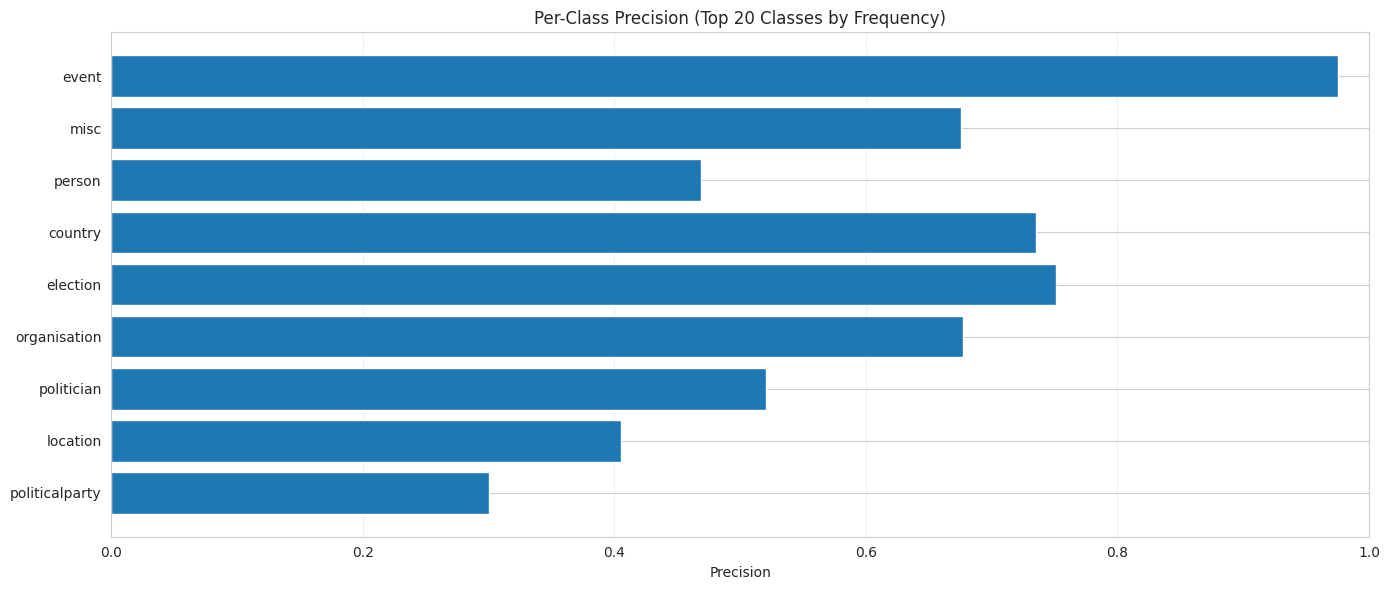

In [14]:
# Plot per-class precision
plt.figure(figsize=(14, 6))

top_classes = class_perf_df.head(20)
plt.barh(range(len(top_classes)), top_classes['Precision'])
plt.yticks(range(len(top_classes)), top_classes['True Class'])
plt.xlabel('Precision')
plt.title('Per-Class Precision (Top 20 Classes by Frequency)')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Save Evaluation Results

Save the evaluation metrics for future reference.

In [15]:
# Save evaluation results
eval_output = OUTPUT_DIR / "evaluation_results.json"

# Prepare results for JSON serialization
json_results = {
    'metrics': {
        k: float(v) if isinstance(v, (np.floating, np.integer)) else v
        for k, v in results.items()
        if k not in ['cluster_mapping', 'confusion_matrix']
    },
    'cluster_mapping': {
        int(k): str(v) for k, v in cluster_mapping.items()
    },
    'cluster_purity': {
        int(k): {
            'purity': float(v['purity']),
            'dominant_class': str(v['dominant_class']),
            'size': int(v['size'])
        }
        for k, v in cluster_purity.items()
    }
}

with open(eval_output, 'w') as f:
    json.dump(json_results, f, indent=2)

print(f"Evaluation results saved to: {eval_output}")

# Save DataFrames
purity_df.to_csv(OUTPUT_DIR / "cluster_purity.csv", index=False)
class_perf_df.to_csv(OUTPUT_DIR / "class_performance.csv", index=False)

print(f"Cluster purity saved to: {OUTPUT_DIR / 'cluster_purity.csv'}")
print(f"Class performance saved to: {OUTPUT_DIR / 'class_performance.csv'}")

Evaluation results saved to: outputs/icc_politics_test_improved/evaluation_results.json
Cluster purity saved to: outputs/icc_politics_test_improved/cluster_purity.csv
Class performance saved to: outputs/icc_politics_test_improved/class_performance.csv


## Summary

This notebook provides comprehensive evaluation of your ICC pipeline results:

1. **Clustering Quality Metrics**: AMI, ARI, V-Measure, Homogeneity, Completeness
2. **Mapping-Based Metrics**: Precision, Recall, F1-Score using Hungarian algorithm
3. **Cluster Analysis**: Purity, size distribution, dominant classes
4. **Per-Class Performance**: How well each true entity type is captured
5. **Visualizations**: Confusion matrices, purity distributions, performance charts

The results are saved in the output directory for future reference.